# Introduction

This notebook covers contents from the lecture "Metabilic Regulation" held by Prof. Dr. Schuster at the Friedrich-Schiller-University in Jena.<br>
It is directed at students from Bioinformatics as well as students from other fields as Molecular Life Sciences, Biochemistry, etc.

## What it is / provides
- A brief summary of the content of the lecture with focus on the mathematical concepts
- An easy frame for self-teaching
- Implementation of mathematical procedures adaptable to a wide variety of examples
- Simple interfaces that require little to no programming skills (Explanations and examples are given as needed)
- Straightforward visualizations that adapt according to the user input

It is an addition to the lectures, not a substitution!

## Usage

### 1. Jupyter-Notebooks
The simplest way to use this notebook is to upload it to https://jupyter.org/try-jupyter/lab

All code cells start with a comment that tells what to do with it.<br>
* \### ADAPT ME \###<br>
In these cells the input for the various tasks is given. You can change them to your needs and run the cells to update the inpute
* \### I UPDATE THE DISPLAY \###<br>
These cells adapt the visualizations to your input
* \### I PROVIDE CODE \###<br>
These cells provide code used in the the first two kind of cells. In order to run the first two kind of cells you need to have these cells run first.
It is best to use "Run all" before making any changes.

Although you really don't need to bother with the code of the second and third type of code cells, you are more than wellcome to read it, rearrange it, change it and use it in your own projects.

### 2. Python:

Some things you need to know about:

**Lists (lst)**<br>
An ordered collection of objects.<br>
Initializing a list:<br>
list = [ ] (An empty list)<br>
list = [1, 2, 5] (A list containing the numbers 1, 2 and 5)<br>
https://www.geeksforgeeks.org/python-lists/


**Dictionaries (dict)**<br>
An unordered collection of key - value pairs that implements a unique mapping between discrete sets<br>
Initializing a map:<br>
dictionary = { } (An empty dictionary)<br>
dictionary = {'yes': 1, 'no': 0} (A dictionary corresponding to a mapping from {'yes','no'} to {'1','0})<br>
https://www.geeksforgeeks.org/python-dictionary/

**Sympy**<br>
Sympy (symbolic python) is a computer algebra system for python.<br>
This notebook uses a lot of it, however it is sufficient for you to know how to define equations in sympy.<br>


In [10]:
### I PROVIDE CODE ###

from math       import log2
from matplotlib import pyplot
from networkx   import DiGraph, draw_networkx_edge_labels, draw_networkx_edges, draw_networkx_labels, draw_networkx_nodes, get_edge_attributes, spring_layout
from numpy      import linspace
from pandas     import DataFrame
from sympy      import diff, Eq, Matrix, parse_expr, solve, Symbol, symbols

In [11]:
### I PROVIDE  CODE ###

# 1. REACTION NETWORKS

class Reaction:

    def __init__(self, reactants, products, reversible=False):
        '''
        Parameters:
            reactants  (dict), key:   molecular species (str)
                               value: stochiometric coeffficient
            products   (dict), key:   molecular species (str)
                               value: stochiometric coeffficient
            reversible (bool), optional parameter
        Returns:

        '''
        self.reactants  = reactants
        self.products   = products
        self.reversible = reversible

    def equation(self):
        '''
        Parameters:

        Returns:
            equation (str), the chemical notion of the equation of the reaction
        '''
        equation = ''
        # reactants with stoichiometric factors
        for i, reactant in enumerate(self.reactants):
            if self.reactants[reactant] > 1:
                equation += f'{self.reactants[reactant]} '
            equation += f'{reactant} '
            if i<len(self.reactants)-1:
                equation += '+ '
        # arrow with stoichiometric factors
        equation += (lambda x: '<-> ' if (self.reversible) else '-> ')(self)
        # products
        for i, product in enumerate(self.products):
            if self.products[product] > 1:
                equation += f'{self.products[product]} '
            equation += f'{product} '
            if i<len(self.products)-1:
                equation += '+ '
        return equation
    
class Reaction_network:

    def __init__(self, reactions):
        '''
        Parameters:
            reactions (list), a list of reactions
        Returns:

        We can use reversible reactions as input, however they will be converted to two irreversible reactions 
        '''
        self.molecules = list(set([key for reaction in reactions for key in reaction.reactants.keys()]+
                                  [key for reaction in reactions for key in reaction.products.keys()]))
        self.reactions = []
        for reaction in reactions:
            if reaction.reversible:
                self.reactions.append(Reaction(reaction.reactants, reaction.products))
                self.reactions.append(Reaction(reaction.products, reaction.reactants))
            else:
                self.reactions.append(reaction)

    def stoichiometric_matrix(self):
        '''
        Parameters:

        Returns:
            N (2D-array) the stoichiometric matrix of the reaction network
        '''
        N = [[0 for reaction in self.reactions] for molecule in  self.molecules]
        for i, molecule in enumerate(self.molecules):
            for j, reaction in enumerate(self.reactions):
                consumption = reaction.reactants[molecule] if molecule in reaction.reactants.keys() else 0
                production  = reaction.products[molecule]  if molecule in reaction.products.keys()  else 0
                N[i][j]= production - consumption
        return N
    
    def display_stochiometric_matrix(self):
        df =  DataFrame(self.stoichiometric_matrix(), index=self.molecules)
        display(df)

    def graph(self):
        '''
        Parameters:

        Returns:
            graph (networkx.DiGraph), graph  representation of the reaction network
        '''
        graph = DiGraph()
        for i, reaction in enumerate(self.reactions):
            for j, reactant in enumerate(reaction.reactants):
                graph.add_edge(reactant, f'R{i+1}', stoichiometric_factor=reaction.reactants[reactant])
            for j, product in enumerate(reaction.products):
                graph.add_edge( f'R{i+1}', product, stoichiometric_factor=reaction.products[product])
        return graph
    
    def show_graph(self):
        '''
        Graphical depiction of the reaction network on a matplotlib plot using networkx
        '''
        graph     = self.graph()
        positions = spring_layout(graph)
        # Nodes
        draw_networkx_nodes(graph,
                            pos=positions,
                            nodelist=[f'R{i+1}' for i in range(len(self.reactions))],
                            node_size=2500,
                            node_color='green')
        draw_networkx_nodes(graph, 
                            pos=positions,
                            nodelist=[molecule for molecule in self.molecules],
                            node_size=2500,
                            node_color='blue')
        # Labels
        draw_networkx_labels(graph,
                            pos=positions,
                            labels={node: node for node in graph.nodes()},
                            font_size=25)
        draw_networkx_edge_labels(graph,
                                  pos=positions,
                                  edge_labels=get_edge_attributes(graph, 'stoichiometric_factor'),
                                  label_pos=0.33,
                                  font_size=15)                      
        # Edges
        draw_networkx_edges(graph,
                            pos=positions,
                            node_size=2500,
                            width=3,
                            connectionstyle="arc3,rad=0.3")
        pyplot.show()

# 2. KINETICS

class mass_action_model:

    def __init__(self, reaction_network):
       self.reaction_network = reaction_network
       self.ode_strings      = self.mass_action_model_from_reaction_network(reaction_network)

    def mass_action_model_from_reaction_network(self, reaction_network):
        '''
        Parameters:
            reaction_network (Reaction_network)
        Returns
            odes (list), a list of formatted strings each representing an ordinary differential equation 
        '''
        N = reaction_network.stoichiometric_matrix()
        odes = ['' for molecule in reaction_network.molecules]
        for i, molecule in enumerate(reaction_network.molecules):
            for j, reaction in enumerate(reaction_network.reactions):
                if N[i][j]:
                    if N[i][j]<0:
                        if odes[i]=='':
                            sign= '-'
                        else:
                            sign=' - '
                    else:
                        if odes[i]=='':
                            sign= ' '
                        else:
                            sign=' + '
                    factor    = f'{abs(N[i][j])}' if abs(N[i][j])>1 else ''
                    parameter = f'k{j}*'
                    variables = ''
                    for k, reactant in enumerate(reaction.reactants):  
                        exponent  = f'**{reaction.reactants[reactant]}' if reaction.reactants[reactant]>1 else ''
                        variables = reactant+exponent
                    odes[i] += f'{sign}{factor}{parameter}{variables}'
        return {molecule: ode for molecule, ode in zip(reaction_network.molecules, odes)}

    def ode_equations(self):
        return [Eq(Symbol(f'd{molecule}/dt'), parse_expr(self.ode_strings[molecule].replace('=',','))) for molecule in self.reaction_network.molecules]
    
    def display_odes(self):
        for ode in self.ode_equations():
            display(ode)

### I PROVIDE  CODE ###

def colors_of_the_rainbow():
    '''
    Parameters:
    
    Returns:
        colors_of_the_rainbow (list), a list of strings each of it a hexcode corresponding to a color of the rainbow
    '''
    return ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#EE82EE']

def michaelis_menten_variables():
    '''
    Parameters:
    
    Returns:
        michaelis_menten_variables (tuple), the sympy.Symbols of the Michaelis-Menten kinetics
    '''
    S     = Symbol('[S]')
    v_max = Symbol('v_{max}')
    v     = Symbol('v')
    K_m   = Symbol('K_m')
    return S, v_max, v, K_m

def michaelis_menten_equation():
    '''
    Parameters:
    
    Returns:
        michaelis_menten_equation (sympy.Eq)
    '''
    S, v_max, v,  K_m = michaelis_menten_variables()
    return Eq(v, (S*v_max) / (K_m + S))

def plot_michaelis_menten_curve(axes, v_max_value=1, K_m_value=1, S_max=10, color='black'):
    '''
    Parameters:
        axes        (pyplot subplot),
        v_max_value (float),
        K_m_value   (float),
        S_max_value (float)
    Plots a Michaelis-Menten-curve on axes with chosen parameters
    '''
    S, v_max, v, K_m = michaelis_menten_variables()
    v        = michaelis_menten_equation().subs({v_max: v_max_value, K_m: K_m_value})
    S_values = linspace(0, S_max, num=100)
    v_values = [v.evalf(subs={S: s}).rhs for s in S_values]
    axes.plot(S_values, v_values, label=f'K_m={K_m_value}', color=color, linewidth=3)
    axes.plot([0, K_m_value], [0.5, 0.5], color='black')
    axes.plot([K_m_value, K_m_value], [0, 0.5], color=color, linestyle='dotted', linewidth=3)

def plot_lineweaver_burk_curve(axes, v_max_value=1, K_m_value=1, S_max=1, color='black'):
    '''
    Parameters:
        axes        (pyplot subplot),
        v_max_value (float),
        K_m_value   (float),
        S_max_value (float)
    Plots a Michaelis-Menten-curve on axes with chosen parameters
    '''
    axes.plot([-1/K_m_value, 10], [0, (1/v_max_value)+(K_m_value/v_max_value)], label=f'K_m={K_m_value}', color=color, linewidth=3)

def michaelis_menten_plot(K_m_constants, axes):
    axes.set_title('Michaelis-Menten kinetics - Regular plot', fontsize=20)
    axes.set_xlim(xmin=0, xmax=max(K_m_constants)/0.666)
    for i, const in enumerate(K_m_constants):
        plot_michaelis_menten_curve(axes, K_m_value=const, S_max=max(K_m_constants)/0.666, color=colors_of_the_rainbow()[i])
    axes.set_xlabel('[S]', fontsize=25)
    axes.set_ylabel('v', fontsize=25)
    axes.legend(fontsize=15)

def lineweaver_burk_plot(K_m_constants, axes):
    axes.set_title('Michaelis-Menten kinetics - Lineweaver burk plot', fontsize=20)
    axes.set_ylim(ymax=1)
    axes.set_xlim(xmin=-max([1/c for c in K_m_constants]), xmax=max([1/c for c in K_m_constants]))
    axes.plot([0,0],[0,1],color='black')
    for i, const in enumerate(K_m_constants):
        plot_lineweaver_burk_curve(axes, K_m_value=const, S_max=max(K_m_constants)/0.666, color=colors_of_the_rainbow()[i])
    axes.set_xlabel('1/[S]', fontsize=25)
    axes.set_ylabel('1/v', fontsize=25)
    axes.legend(fontsize=15)

def hill_variables():
    '''
    Parameters:
    
    Returns:
        hill_variables (tuple), the sympy.Symbols of the Michaelis-Menten kinetics
    '''
    S     = Symbol('[S]')
    v_max = Symbol('v_{max}')
    v     = Symbol('v')
    K_D   = Symbol('K_D')
    return S, v_max, v, K_D

def hill_equation(n):
    '''
    Parameters:

    Returns:
        michaelis_menten_equation (sympy.Eq)
    '''
    S, v_max, v,  K_D = hill_variables()
    return Eq(v, ((S**n)*v_max) / (K_D + (S**n)))

def plot_hill_curve(axes, n, v_max_value=1, K_D_value=1, S_max=10, color='black'):
    '''
    Parameters:
        axes        (pyplot subplot),
        v_max_value (float),
        K_m_value   (float),
        S_max_value (float),
    Plots a Michaelis-Menten-curve on axes with chosen parameters
    '''
    S, v_max, v, K_D = hill_variables()
    v        = hill_equation(n).subs({v_max: v_max_value, K_D: K_D_value})
    S_values = linspace(0, S_max, num=100*(int(log2(n)+1)))
    v_values = [v.evalf(subs={S: s}).rhs for s in S_values]
    axes.plot(S_values, v_values, label=f'K_D={K_D_value}, n={n}', color=color, linewidth=3)

def plot_3_3_1_curve(axes, v_1, v_max_2, K_m_2):
    '''
    Parameters:
        axes    (float),
        v_1     (float),
        v_max_2 (float),
        K_m_2   (float)
    Returns:

    Plots a curve for the example with the given parameters
    '''
    S_2, dS_2_dt = symbols('[S_{2}] dS_{2}/dt')
    equation = Eq(dS_2_dt, v_1 - ((v_max_2*S_2)/(K_m_2+S_2)))
    display(equation)
    S_values = linspace(0.1, 10, num=100)
    v_values = [equation.evalf(subs={S_2: s}).rhs for s in S_values]
    axes.plot(S_values, v_values, color='red', linewidth=3)
    axes.axhline(0, color='black')

# 3. STATIONARY STATES

def jacobian_matrix(equations):
    '''
    Parameters:
        equations (list), a list of equations (sympy.Eq)
    Returns:
        jacobian  (2D-array)
    '''
    variables = [Symbol(str(equation.lhs.free_symbols).split('/')[0][2:]) for equation in equations]
    jacobian  = [[diff(equation.rhs, variable) for variable in variables] for equation in equations]
    return Matrix(jacobian)

# Metabolic and regulatory networks

# 1. Reaction networks

From a mathematical perspective reaction networks are a pairs $<M,R>$ with $M=\{s_1,...,s_n\}$ a set of molecular species and R a set of pairs of multisets, called reactants and products of a reaction, each consisting of elements from M. From a chemical perspective it is simply a description of possible ways to create, destroy or to transform molecules.

A very simple example for a chemical reaction network with only a single reaction:<br>
$<M,R>~=~<\{C_{6}H_{12}0_{2},~CO_{2},~H_{2}O,O_2\},\{\{C_{6}H_{12}0_{6},~O_2,~O_2,~O_2,~O_2,~O_2,~O_2\},~\{CO_{2},~CO_{2},~CO_{2},~CO_{2},~CO_{2},~CO_{2},~H_{2}O,~H_{2}O,~H_{2}O,~H_{2}O,~H_{2}O,~H_{2}O\}\}>$<br>
is the mathematically correct representation of the oxidation of glucose (cellular respiration). However here the typical chemical notation comes in way more handy:<br>
$R_1: C_{6}H_{12}~+~6~0_{2}~\rightarrow~6~CO_{2}~+~6~H_{2}O$

Chemical reactions can neither create nore destroy elementary particles, only rearrange them (**law of mass conservation**).
This means we need to be careful with the **stoichiometric coefficients** that denote the amount of molecules of a species that take part in a reaction.
For practical purposes however it is often necessary to exclude some molecular species and set bounderies for the systems we are considering.
We can than have reactions for inflow to and outflow from the system.<br>

The **stochiometric matrix** is a usefull representation of a reaction network and contains the net production of all species for all the reactions of the network.
It is defined as $(N_{i,j})$ with $N_{i,j}$ being the net production of species $i$ in reaction $j$

In [12]:
### ADAPT ME ###
reactants = {'C6H12O6': 1, 'O2': 6}
products  = {'CO2': 6, 'H20': 6}
### ADAPT ME ###
reversible_reaction   = Reaction(reactants, products, reversible=True) 
irreversible_reaction = Reaction(reactants, products)                   # reversible is an optional parameter and defaults to False

In [13]:
### I UPDATE THE DISPLAY ###
print(f'Example reaction (reversible):\n{reversible_reaction.equation()}\n')
print(f'Example reaction (irrreversible):\n{irreversible_reaction.equation()}\n')

Example reaction (reversible):
C6H12O6 + 6 O2 <-> 6 CO2 + 6 H20 

Example reaction (irrreversible):
C6H12O6 + 6 O2 -> 6 CO2 + 6 H20 



In [14]:
### ADAPT ME ###
reaction_1 = Reaction({'A': 1, 'X': 1}, {'X':2}) 
reaction_2 = Reaction({'X': 2, 'Y': 1}, {'X':3})
reaction_3 = Reaction({'B': 1}, {'X':1})
reaction_4 = Reaction({'X': 1}, {'D':1})
reactions = [reaction_1, reaction_2, reaction_3, reaction_4]
reaction_network = Reaction_network(reactions)
### ADAPT ME ###

Example reaction network:
A + X -> 2 X 
2 X + Y -> 3 X 
B -> X 
X -> D 

Stoichiometric matrix:


,0,1,2,3
Y,0,-1,0,0
X,1,1,1,-1
B,0,0,-1,0
A,-1,0,0,0
D,0,0,0,1


Graph representation:


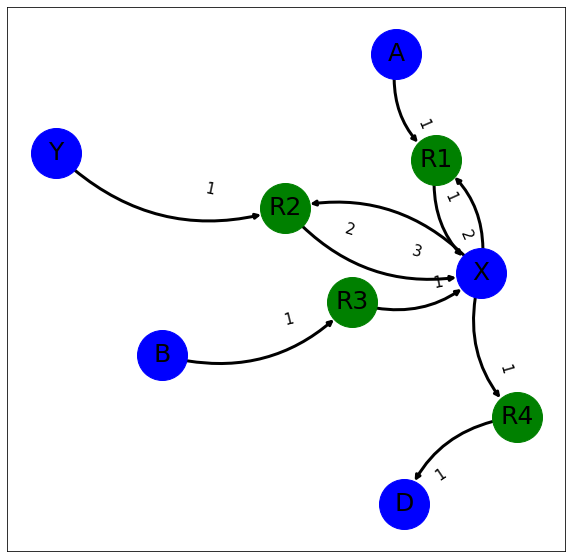

In [15]:
###  I UPDATE THE DISPLAY ###

print('Example reaction network:')
for reaction in reaction_network.reactions:
    print(reaction.equation())
print('\nStoichiometric matrix:')
reaction_network.display_stochiometric_matrix()
fig, axes = pyplot.subplots(figsize=(10,10))
print('Graph representation:')
reaction_network.show_graph()

# 2. Kinetics

Kinetics deal with the rates at which chemical reactions happen.<br>
Mostly they are determined by the concentrations of the reactants and the involvment of catalysts.<br>
However, factors as temperature, pH, pressure and others play a role here.

## 2.1. Mass action kinetics

A simple kinetic based on the collision probabilities of the reactants.

In [16]:
### I UPDATE THE DISPLAY ###

model = mass_action_model(reaction_network)
model.display_odes()

Eq(dY/dt, -Y*k1)

Eq(dX/dt, B*k2 + X*k0 - X*k3 + Y*k1)

Eq(dB/dt, -B*k2)

Eq(dA/dt, -X*k0)

Eq(dD/dt, X*k3)

## 2.2. Enzyme kinetics

Enzymes have catalytic activity. That means they can participate in reactions which they accelerate, often by several orders of magnitude, but are not consumed in the reaction.

### 2.2.1. Michaelis-Menten-kinetics

The simplest case of enzyme reaction is the transformation of a single reactant molecule to a single product molecule.

The catalytic reaction could be considered to consist of smaller (reversible) reactions:<br>
$ E~+~S~\xLeftrightarrow[k_{-1}]{k_1}~ES~\xLeftrightarrow[k_{-2}]{k_2}~EP~\xLeftrightarrow[k_{-3}]{k_3}~E+P $
1. Enzyme substrate complex formation<br>
2. Conversion of the substrate<br>
3. Product release<br>

**Deriving the Michaelis-Menten equation**

We can simplify the reaction system from above to<br>
$ E~+~S~\xLeftrightarrow[k_{-1}]{k_1}~ES~\xLeftrightarrow[k_{-2}]{k_2}~E+P $<br>

This translates to the ordinary differential equations:<br>
1. $\frac{dES}{dt}=k_1[E][S]_1-(k_{-1}+k_2)[ES]+k_{-2}[E][P]$<br>

2. $\frac{dE}{dt}=-k_1[E][S]_1+(k_{-1}+k_2)[ES]-k_{-2}[E][P]$<br>

Observations
1. $\frac{dES}{dt}=-\frac{dE}{dt}$

2. $[E]+[ES] = constant$ <br>

(conservation relation)

Because of the second observation we can define:<br>
$[E_{total}]=[E]+[ES]$

Next, we assume $[E_{total}]<<[S]$ and thus $v_1\approx v_2$ meaning we can state $\frac{d[ES]}{dt}=0$ is a good approximation (quasi stationarity).

Substituting this in the second differential equation gives:<br>

$0 = -k_1[E][S]_1+(k_{-1}+k_2)[ES]-k_{-2}[E][P]$

$\Leftrightarrow 0 = -k_1[E][S]_1+(k_{-1}+k_2)([E_{total}]-[E])-k_{-2}[E][P]~~~~~~~~~~~~~~~~(Observation~2)$

$\Leftrightarrow 0 = -k_1[E][S]_1+(k_{-1}+k_2)[E_{total}]-(k_{-1}+k_2)[E]-k_{-2}[E][P]$

$\Leftrightarrow k_1[E][S]_1+(k_{-1}+k_2)[E]+k_{-2}[E][P] =(k_{-1}+k_2)[E_{total}]$

$\Leftrightarrow [E](k_1[S]_1+(k_{-1}+k_2)+k_{-2}[P]) = (k_{-1}+k_2)[E_{total}]$

We set $N=(k_1[S]_1+(k_{-1}+k_2)+k_{-2}[P])$ so we can simplify the previous equation to<br>

$[E] = \frac{(k_{-1}+k_2)[E_{total}]}{N}$<br>

**TO BE CONTINUED...**

**The Michaelis-Menten equation**

The rate of the reaction with fixed enzyme concentration is:

$v([S])=\frac{v_{max}*[S]}{K_m+[S]}$ with:<br>
* $[S]$ substrate concentration
* $v_{max}$ maximum speed
* $K_m$ Michaelis-Menten-constant (specific for each enzyme)

We can look at the slope of $v[S]$ for different $K_m$ and $v_{max}=1$ in the plots below.<br>

In the plot on the left hand side we see that $v=\frac{v_{max}}{2}$ when $[S]=K_m$ which we can also derive from the equation. ($v(K_m)=\frac{v_{max}*K_m}{K_m+k_m} = v_{max}*\frac{K_m}{2*K_m}=\frac{v_{max}}{2}$

The right hand side plot, the linewaver burk plot is a linear representation of the interdependence of $v$ and $[S]$ but it is a liniear plot.<br>
There are two advantages to this plot.
1. We can very easily extract several pieces of information as:<br>
a) The curve pierces the x-axis at $\frac{1}{K_m}$<br>
b) The curve pierces the y-axis at $\frac{1}{v_{max}}$<br>
c) It's slope is $\frac{K_m}{v_{max}}$.
2. Using linear regression analysis we can use this plot to very easily derive $v_{max}$ and $K_m$ from experimental data by curve fitting

In [17]:
### ADAPT ME ###
K_m_constants   = [0.25, 0.5, 1, 2, 4, 8, 16] # 1-7 values
### ADAPT ME ###

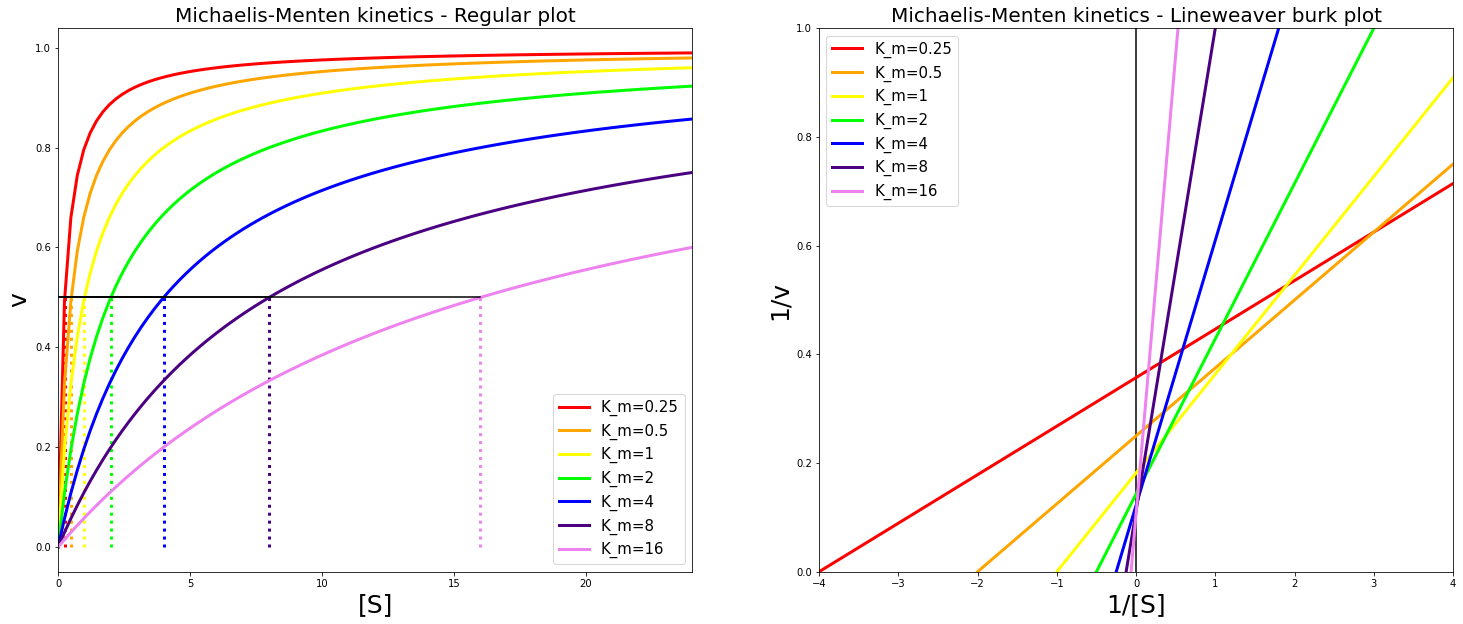

In [18]:
### I UPDATE THE DISPLAY ###

fig, axes = pyplot.subplots(1,2, figsize=(25,10))
michaelis_menten_plot(K_m_constants, axes[0])
lineweaver_burk_plot(K_m_constants, axes[1])
#plot_michaelis_menten_curve(axes[0], v_max_value=1, K_m_value=1, S_max=10, color='black')
#plot_lineweaver_curve(axes[1], v_max_value=1, K_m_value=1, S_max=10, color='black')

Lets see how the variables depend on each other by solving the eqaution for each of them:

In [19]:
### I UPDATE THE DISPLAY ###

for variable in michaelis_menten_variables():
    for i, solution in enumerate(solve(michaelis_menten_equation(), variable)):
        display(Eq(Symbol(f'{variable}'), solution))

Eq([S], -K_m*v/(v - v_{max}))

Eq(v_{max}, v*(K_m + [S])/[S])

Eq(v, [S]*v_{max}/(K_m + [S]))

Eq(K_m, [S]*(-v + v_{max})/v)

### 2.2.2. Michaelis-Menten kinetics for bimolecular reactions

**TO DO**

### 2.2.3. Cooperative kinetics (Hill-kinetics)

There exist enzymes with multiple binding sites for substrate molecules.<br>
In some cases the binding of substrate molecules makes the binding of more substrate molecules easier (positive cooperativity),<br>
while in other cases it makes the binding of more substrate molecules easier (positive cooperativity)<br>
This is described by the Hill-equation:<br>

$v([S])=\frac{v_{max}[S]^n}{K_A^n+[S]}$ with:<br>
* $[S]$ substrate concentration
* $v_{max}$ maximum speed
* $n$ Hill-coefficient (the number of involved molecules)
* $K_A$ Michaelis-Menten-constant (specific for each enzyme)

This equation is a generalized version of the Michaelis-Menten kinetics (n=1)

The curve is sigmoid and it gets steeper with increasing $n$.<br>
This can be used to facilitate on-/off-switches based on a concentration threshhold (which is controllable by $K_D$), basically an analog-to-digital-converter. (Roughly)

In [20]:
### ADAPT ME! ###
left_K_D  = 1
left_n    = [1, 2, 4, 8, 16, 32, 64] # 1-7 values

right_n  =  4
right_K_D = [0.125, 0.25, 0.5, 1, 2, 4, 8] # 1-7 values
### ADAPT ME! ###

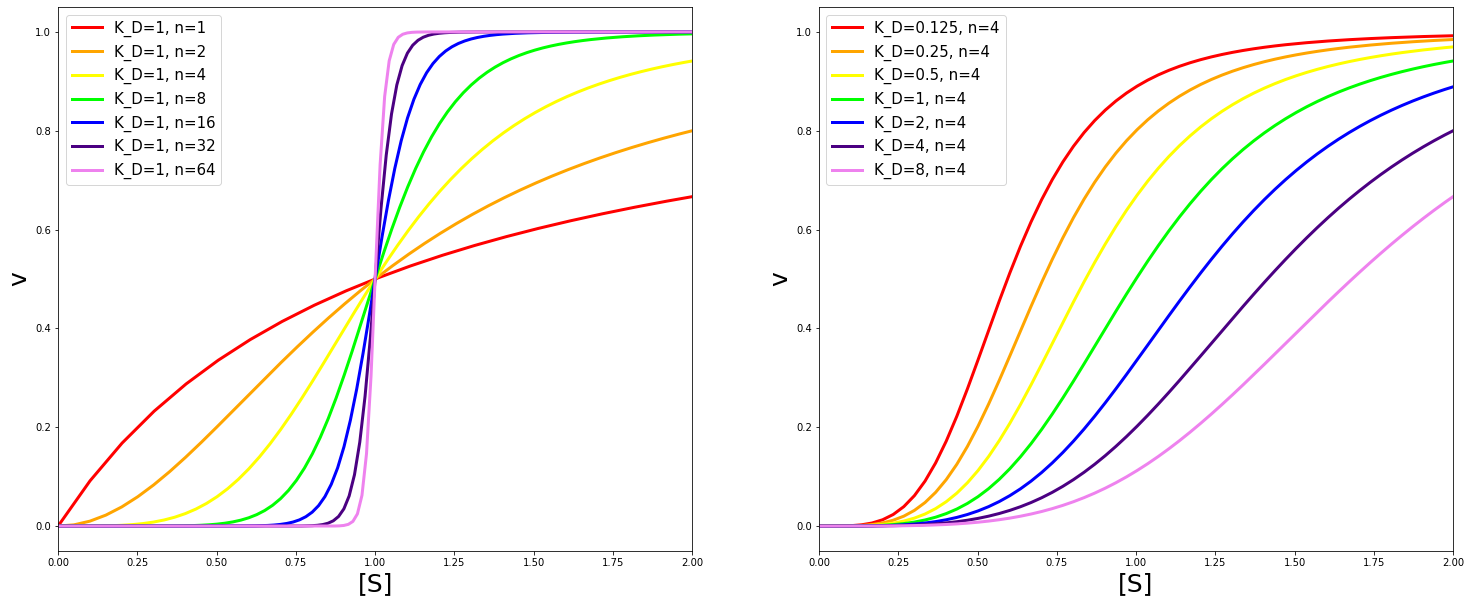

In [21]:
### I UPDATE THE DISPLAY! ###

fig, axes = pyplot.subplots(1,2, figsize=(25,10))

# Left plot (variable n)
colors = colors_of_the_rainbow()
axes[0].set_xlim(xmin=0, xmax=2)
for i, n in enumerate(left_n):
    plot_hill_curve(axes[0], n, K_D_value=left_K_D, color=colors[i])
axes[0].legend(fontsize=15)
axes[0].set_xlabel('[S]', fontsize=25)
axes[0].set_ylabel('v', fontsize=25)

# right plot (variable n)
axes[1].set_xlim(xmin=0, xmax=2)
for i, K_D in enumerate(right_K_D):
    plot_hill_curve(axes[1], right_n, K_D_value=K_D, color=colors[i])
axes[1].legend(fontsize=15)
axes[1].set_xlabel('[S]', fontsize=25)
axes[1].set_ylabel('v', fontsize=25)
pyplot.show()

### 2.2.4. Inhibition kinetics

Inhibitors decrease enzyme activity.

There are multiple types of inhibition kinetics
1. Competitive
2. Non-competetive
3. Incompetetive
4. Mixed 
5. Substrate
6. Irreversible

**1. Competitive**

The inhibitor competes with the substrate for substrate binding site. <br 
Both substrate and inhibitor can bind to the enzyme. However, the enzyme cannot process the inhibitor.

$ (EI~\xLeftrightarrow[k_{-3}]{k_3}~I~+~(E)~+~S~\xLeftrightarrow[k_{-1}]{k_1}~ES~\xLeftrightarrow[k_{-3}]{k_3}~E+P) $

(The parentheses indicate that E can either interact with $I$ or $S$ not both at the ame time)

Since EI cannot be converted, an equilibrium between EI and free E can be assumed:

$\frac{[E][I]}{[EI]}=\frac{k_{-3}}{k_3}=k_I$

$\Leftrightarrow \frac{[E][I]}{K_I} = [EI]$

Together with the conservation relation $[E]+[ES]+[EI]=[E_{total}]$, we obtain

$[E_{total}] = [E]+[ES]+\frac{[E][I]}{K_I}$

$\Leftrightarrow [E] + \frac{[E][I]}{K_I} = [E_{total}]-[ES]$

$\Leftrightarrow [E](1 + \frac{[I]}{K_I}) = [E_{total}]-[ES]$

$\Leftrightarrow [E] = \frac{[E_{total}]-[ES]}{(1 + \frac{[I]}{K_I})}$

We insert this into the quasi steady state approximation for $[ES]$ (similar to what we did in 2.2.1. for the michaelis-menten-kinetics)

$k_1[S]\frac{[E_{total}]-[ES]}{(1 + \frac{[I]}{K_I})}-(k_{-1}+k_2)[ES]=0$

resulting in

$v=k_2[ES]=\frac{k_2[E_{total}][S]}{K_m (1+\frac{[I]}{K_I})+[S]}$

**2. Non-competetive**

**3. Incompetetive**

**4. Mixed**

**5. Substrate**

**6. Irreversible**

# 3. Stationary states

## 3.1. External and internal metabolites

In chemical systems we can distinguish two kind of metabolites: external vs internal.<br>
External metabolites are considered to have constant concentration, either because of their vast abundance (e.g. Water) or because they are well regulated (e.g. blood sugar)

## 3.2. Stationary states

In stationary states molecule concentrations are invariable.<br>
While reactions can occur, the overall consumption of molecules equals their production.<br>
This is equivalent to writing:

$Nv=0$ with $N$ the stoichiometric matrix and $v=(v_j)$ the vector of reaction rates.

## 3.3. Stability analysis

Next, let us look at the question of how systems in states of equilibrium react to external perturbations (i.e. spontaneous changes in concentrations)

If the stationary state is **stable** the system will return to the stationary state after being perturbed.<br>
If the stationary state is **unstable** the system will not return to the stationary state after being perturbed.<br>

### 3.3.1. One-dimensional systems

Let's consider a simple system with only two irreversible enzymatic reactions.

$S_1 \rightarrow S_2 \rightarrow S_3$ with $S_1$ and $S_3$ being external metabolites (i.e. $[S_1]$ and $[S_3]$ are constant)

Since $[S_1]$ is constant $v_1$ is also constant, $v_2$ however depends on $[S]$.

$v_2=\frac{v_{max,2}[S_2]}{K_{m,2}+[S_2]}$

In the stationary state $S_2$ is consumed at the same rate as it produced. Therefore $v_1=v_2$.

$[S_2]= \frac{v_1 K_{m,2}}{v_{max,2}-v_1}$

We can see $v_{max,2}$ must be greater than $v_1$ 

$\frac{d[S_2]}{dt}=v_1-v_2=v_1-\frac{v_{max,2}[S_2]}{K_{m,2}+[S_2]}$ is the rate of change of $S_2$

In [22]:
### ADAPT ME! ###
v_1     = 1
v_max_2 = 2
K_m_2   = 2
### ADAPT ME! ###

Eq(dS_{2}/dt, -2*[S_{2}]/([S_{2}] + 2) + 1)

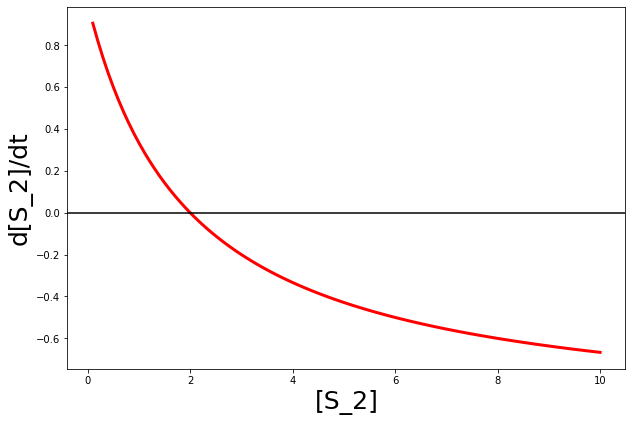

In [23]:
### I UPDATE THE DISPLAY! ###

fig, axes = pyplot.subplots(figsize=(10,6.66))
plot_3_3_1_curve(axes, v_1, v_max_2, K_m_2)
axes.set_xlabel('[S_2]', fontsize=25)
axes.set_ylabel('d[S_2]/dt', fontsize=25)
pyplot.show()

The curve pierces the x-axis at the steady state.<br>
For $v_{max,2}<v_1$ we do not observe steady states since the production of $S_2$ in reaction 1 is always higher than it's consumption in reaction 2.<br>
For $v_{max,2}>v_1$ we observe steady states.<br>
At concentrations of $S_2$ lower than the stationary state $[S_2]$ changes at a positive rate meaning it converges to the stationary state.<br>
At concentrations of $S_2$ bigger than the stationary state $[S_2]$ changes at a negative rate meaning it also converges to the stationary state.<br>
The steady-state is therefore stable.

### 3.3.2. Multi-dimensional systems

We can denote autonomous systems as a list of differential equations (as we did in section 2.1.).

$\frac{[S_1]}{dt}=f_1([S_1],...,[S_2])$

...

$\frac{[S_n]}{dt}=f_n([S_1],...,[S_2])$

The **jacobian matrix** of such a system is defined as $J=(\frac{df_i}{[S_j]})$
(The derivatives of all components by all variables)

In [30]:
### ADAPT ME! ###
dX_dt, dY_dt, X, Y = symbols('dX/dt dY/dt X Y')
ode_1 = Eq(dX_dt, (-X**3+Y))
ode_2 = Eq(dY_dt, (-Y**2+X))
odes  = [ode_1, ode_2]

# odes = model.ode_equations() # Remove th '#' to use the example reaction network with mass action kinetics
### ADAPT ME! ###

'\nodes = model.ode_equations() # Use this line for the example reaction network with mass action kinetics\n'

In [31]:
### I UPDATE THE DISPLAY! ###
print('ODEs')
for ode in odes:
    display(ode)
print('Jacobian matrix:')
display(jacobian_matrix(odes))

ODEs


Eq(dX/dt, -X**3 + Y)

Eq(dY/dt, X - Y**2)

Jacobian matrix:


Matrix([
[-3*X**2,    1],
[      1, -2*Y]])